شروع و دریافت  اطلاعات

In [107]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from keras.layers import LSTM, Dense, Input, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Input
import MetaTrader5 as mt5
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.model_selection import KFold

In [108]:
# تنظیمات
symbol = 'EURUSD'
timeframe = mt5.TIMEFRAME_H1
number_of_candles = 99999

mt5.initialize()
# login = '2424394'
# password = 'Aa@12345678'
# server = 'AMarkets-Real'
# mt5.login(login, password, server)


def get_data(symbol, timeframe, number_of_candles):
    if not mt5.initialize():
        print("Failed to initialize MT5")
        return None

    rates = mt5.copy_rates_from_pos(symbol, timeframe, 0, number_of_candles)
    mt5.shutdown()

    candles_data = pd.DataFrame(rates)
    candles_data['time'] = pd.to_datetime(candles_data['time'], unit='s')
    return candles_data


candles = get_data(symbol, timeframe, number_of_candles)

# تغییر نام
candles = candles.rename(
    columns={'open': 'O', 'high': 'H', 'low': 'L', 'close': 'C', 'tick_volume': 'vol'})
candles = candles.drop(columns=['real_volume', 'spread'])


candles

,time,O,H,L,C,vol
0,2008-08-13 11:00:00,1.49170,1.49370,1.49110,1.49190,928
1,2008-08-13 12:00:00,1.49210,1.49210,1.48550,1.48710,1226
2,2008-08-13 13:00:00,1.48700,1.49040,1.48630,1.48910,743
3,2008-08-13 14:00:00,1.48900,1.49350,1.48890,1.49250,1106
4,2008-08-13 15:00:00,1.49240,1.49240,1.48640,1.48710,1163
...,...,...,...,...,...,...
99994,2024-10-01 09:00:00,1.11373,1.11410,1.11309,1.11344,1872
99995,2024-10-01 10:00:00,1.11344,1.11370,1.11116,1.11149,3141
99996,2024-10-01 11:00:00,1.11153,1.11201,1.10980,1.11016,2529
99997,2024-10-01 12:00:00,1.11017,1.11144,1.10921,1.10951,2251


پیدا کردن فراکتال ها

In [109]:
# استفاده از تابع fractals
left_n = 3  # تعداد کندل‌های چپ
right_n = 2  # تعداد کندل‌های راست

# تعریف تابع fractals


def fractal(candles, left_n, right_n):
    # ایجاد ستون‌های اولیه برای فراکتال‌ها با مقدار False
    candles['up_f'] = True
    candles['low_f'] = True

    # شناسایی فراکتال‌های بالا
    for i in range(1, left_n + 1):
        candles['up_f'] &= (candles['H'] >= candles['H'].shift(i))

    for j in range(1, right_n + 1):
        candles['up_f'] &= (candles['H'] >= candles['H'].shift(-j))

    # شناسایی فراکتال‌های پایین
    for i in range(1, left_n + 1):
        candles['low_f'] &= (candles['L'] <= candles['L'].shift(i))

    for j in range(1, right_n + 1):
        candles['low_f'] &= (candles['L'] <= candles['L'].shift(-j))

    # تبدیل فراکتال‌های بالا و پایین به مقادیر بولی
    candles['up_f'] = np.where(candles['up_f'], True, False)
    candles['low_f'] = np.where(candles['low_f'], True, False)

    return candles


# فراخوانی تابع fractals برای شناسایی فراکتال‌ها
fractals = fractal(candles, left_n, right_n)


# نمایش نتیجه
fractals

,time,O,H,L,C,vol,up_f,low_f
0,2008-08-13 11:00:00,1.49170,1.49370,1.49110,1.49190,928,False,False
1,2008-08-13 12:00:00,1.49210,1.49210,1.48550,1.48710,1226,False,False
2,2008-08-13 13:00:00,1.48700,1.49040,1.48630,1.48910,743,False,False
3,2008-08-13 14:00:00,1.48900,1.49350,1.48890,1.49250,1106,False,False
4,2008-08-13 15:00:00,1.49240,1.49240,1.48640,1.48710,1163,False,False
...,...,...,...,...,...,...,...,...
99994,2024-10-01 09:00:00,1.11373,1.11410,1.11309,1.11344,1872,False,False
99995,2024-10-01 10:00:00,1.11344,1.11370,1.11116,1.11149,3141,False,False
99996,2024-10-01 11:00:00,1.11153,1.11201,1.10980,1.11016,2529,False,False
99997,2024-10-01 12:00:00,1.11017,1.11144,1.10921,1.10951,2251,False,False


In [110]:
# گنترل اینکه فراکتال هست یا نه
fractals['fra'] = fractals.apply(
    lambda row: 'True' if row['up_f'] or row['low_f'] else 'False', axis=1)

fractals[-50:]

,time,O,H,L,C,vol,up_f,low_f,fra
99949,2024-09-27 12:00:00,1.11445,1.11597,1.11372,1.11594,2097,False,False,False
99950,2024-09-27 13:00:00,1.11594,1.11709,1.11557,1.11633,1926,False,False,False
99951,2024-09-27 14:00:00,1.11632,1.11676,1.11590,1.11624,1884,False,False,False
99952,2024-09-27 15:00:00,1.11624,1.12015,1.11541,1.11996,3355,False,False,False
99953,2024-09-27 16:00:00,1.11992,1.12029,1.11795,1.11852,3395,True,False,True
99954,2024-09-27 17:00:00,1.11839,1.11920,1.11694,1.11784,3448,False,False,False
99955,2024-09-27 18:00:00,1.11782,1.11782,1.11540,1.11584,2685,False,False,False
99956,2024-09-27 19:00:00,1.11584,1.11599,1.11464,1.11516,2396,False,True,True
99957,2024-09-27 20:00:00,1.11516,1.11658,1.11504,1.11636,2004,False,False,False
99958,2024-09-27 21:00:00,1.11637,1.11677,1.11597,1.11677,1724,False,False,False


حذف فراکتال های پشت سر هم

In [111]:

fractals['frac'] = False  # ستون جدید برای اکستریم‌ها، پیش‌فرض False

# لیست نهایی اندیس‌هایی که اکستریم هستند
final_rows = []

# لیست‌های موقت برای ذخیره اندیس‌های up_f و low_f
temp_up_f = []  # اندیس‌های up_f
temp_low_f = []  # اندیس‌های low_f

# تابع عمومی برای پیدا کردن اکستریم


def process_fracs(df, frac_list, column, frac_type):
    if len(frac_list) > 0:
        frac_index = find_frac(df, frac_list, column, frac_type)
        final_rows.append(frac_index)
        frac_list.clear()  # خالی کردن لیست موقت

# تابع برای پیدا کردن اکستریم


def find_frac(df, indexes, column, frac_type='max'):
    if frac_type == 'max':
        return df.loc[indexes, column].idxmax()
    elif frac_type == 'min':
        return df.loc[indexes, column].idxmin()


# پردازش ردیف‌ها
for i, row in fractals.iterrows():
    if row['fra']:  # فقط ردیف‌هایی که fra برابر True دارند
        if row['up_f']:  # اگر up_f برابر True باشد
            temp_up_f.append(i)  # ذخیره اندیس up_f
            process_fracs(fractals, temp_low_f, 'L', 'min')
        elif row['low_f']:  # اگر low_f برابر True باشد
            temp_low_f.append(i)  # ذخیره اندیس low_f
            process_fracs(fractals, temp_up_f, 'H', 'max')

# اضافه کردن آخرین اکستریم‌ها
if len(temp_up_f) > 0:
    final_rows.append(find_frac(fractals, temp_up_f, 'H', 'max'))

if len(temp_low_f) > 0:
    final_rows.append(find_frac(fractals, temp_low_f, 'L', 'min'))

# علامت‌گذاری اکستریم‌ها در ستون frac
fractals['frac'] = fractals.index.isin(final_rows)


# نمایش دیتافریم نهایی
fractals[-350:-300]

,time,O,H,L,C,vol,up_f,low_f,fra,frac
99649,2024-09-11 00:00:00,1.10197,1.10198,1.10182,1.10198,58,False,True,True,False
99650,2024-09-11 01:00:00,1.10198,1.10214,1.10195,1.10197,365,False,False,False,False
99651,2024-09-11 02:00:00,1.10197,1.10237,1.10192,1.10201,473,False,False,False,False
99652,2024-09-11 03:00:00,1.10200,1.10227,1.10168,1.10200,1049,False,True,True,False
99653,2024-09-11 04:00:00,1.10201,1.10400,1.10182,1.10367,1641,False,False,False,False
99654,2024-09-11 05:00:00,1.10368,1.10444,1.10327,1.10332,1334,False,False,False,False
99655,2024-09-11 06:00:00,1.10332,1.10426,1.10316,1.10385,1049,False,False,False,False
99656,2024-09-11 07:00:00,1.10386,1.10471,1.10380,1.10465,1108,False,False,False,False
99657,2024-09-11 08:00:00,1.10466,1.10513,1.10426,1.10438,1221,False,False,False,False
99658,2024-09-11 09:00:00,1.10435,1.10490,1.10407,1.10452,1599,False,False,False,False


جاهایی که یک کندل هم فراکتال سقف هست هم فراکتال کف

In [112]:
# پیمایش دیتافریم و چاپ شماره ردیف‌هایی که هر دو ستون up_f و low_f برابر True هستند
for i, row in fractals.iterrows():
    if row['up_f'] and row['low_f']:
        print(f"Row {i}: Both up_f and low_f are True")

        # پیدا کردن اولین ردیف به سمت بالا که low_f یا up_f برابر True باشد
        upper_index = i - 1
        while upper_index >= 0:  # اطمینان از اینکه به ردیف‌های منفی نرسیم
            if fractals.iloc[upper_index]['low_f']:
                print(f"First upper Row {upper_index}: low_f is True")
                break
            elif fractals.iloc[upper_index]['up_f']:
                print(f"First upper Row {upper_index}: up_f is True")
                break
            upper_index -= 1

        # پیدا کردن اولین ردیف به سمت پایین که low_f یا up_f برابر True باشد
        lower_index = i + 1
        # اطمینان از اینکه به ردیف‌های بیش از طول نرسیم
        while lower_index < len(fractals):
            if fractals.iloc[lower_index]['up_f']:
                print(f"First lower Row {lower_index}: up_f is True")
                break
            elif fractals.iloc[lower_index]['low_f']:
                print(f"First lower Row {lower_index}: low_f is True")
                break
            lower_index += 1

fractals[620:670]

Row 236: Both up_f and low_f are True
First upper Row 232: up_f is True
First lower Row 241: up_f is True
Row 1318: Both up_f and low_f are True
First upper Row 1313: up_f is True
First lower Row 1325: up_f is True
Row 1481: Both up_f and low_f are True
First upper Row 1480: low_f is True
First lower Row 1487: low_f is True
Row 2856: Both up_f and low_f are True
First upper Row 2855: low_f is True
First lower Row 2859: up_f is True
Row 4713: Both up_f and low_f are True
First upper Row 4709: low_f is True
First lower Row 4718: low_f is True
Row 4895: Both up_f and low_f are True
First upper Row 4891: low_f is True
First lower Row 4902: low_f is True
Row 5282: Both up_f and low_f are True
First upper Row 5276: up_f is True
First lower Row 5287: low_f is True
Row 5314: Both up_f and low_f are True
First upper Row 5307: low_f is True
First lower Row 5317: up_f is True
Row 6562: Both up_f and low_f are True
First upper Row 6557: up_f is True
First lower Row 6575: low_f is True
Row 6692: Bo

,time,O,H,L,C,vol,up_f,low_f,fra,frac
620,2008-09-18 12:00:00,1.4472,1.4542,1.4467,1.4487,2253,True,False,True,True
621,2008-09-18 13:00:00,1.4488,1.4494,1.4463,1.4469,1370,False,False,False,False
622,2008-09-18 14:00:00,1.4470,1.4509,1.4438,1.4443,2199,False,False,False,False
623,2008-09-18 15:00:00,1.4444,1.4461,1.4353,1.4377,2386,False,False,False,False
624,2008-09-18 16:00:00,1.4381,1.4403,1.4349,1.4376,2351,False,True,True,False
625,2008-09-18 17:00:00,1.4375,1.4413,1.4363,1.4380,2086,False,False,False,False
626,2008-09-18 18:00:00,1.4381,1.4457,1.4362,1.4433,1370,False,False,False,False
627,2008-09-18 19:00:00,1.4435,1.4454,1.4389,1.4398,1666,False,False,False,False
628,2008-09-18 20:00:00,1.4397,1.4400,1.4357,1.4369,1033,False,False,False,False
629,2008-09-18 21:00:00,1.4370,1.4388,1.4286,1.4305,1885,False,True,True,False


حذف یکی از طرفین بالا یا پایین کندل هایی که فراکتال بالا پایین هستند با توجه به فراکتال قبلی

In [113]:
# پیمایش دیتافریم و چاپ شماره ردیف‌هایی که هر دو ستون up_f و low_f برابر True هستند
for i, row in fractals.iterrows():
    if row['up_f'] and row['low_f']:
        print(f"Row {i}: Both up_f and low_f are True")

        # پیدا کردن اولین ردیف به سمت بالا که low_f یا up_f برابر True باشد
        upper_index = i - 1
        while upper_index >= 0:  # اطمینان از اینکه به ردیف‌های منفی نرسیم
            if fractals.iloc[upper_index]['low_f']:
                print(f"First upper Row {upper_index}: low_f is True")
                # اگر فراکتال قبلی low_f باشد، low_f فعلی را False کنیم
                fractals.at[i, 'low_f'] = False
                # پرینت جایی که low_f به False تنظیم شده است
                print(f"Row {i}: low_f set to False")
                break
            elif fractals.iloc[upper_index]['up_f']:
                print(f"First upper Row {upper_index}: up_f is True")
                # اگر فراکتال قبلی up_f باشد، up_f فعلی را False کنیم
                fractals.at[i, 'up_f'] = False
                # پرینت جایی که up_f به False تنظیم شده است
                print(f"Row {i}: up_f set to False")
                break
            upper_index -= 1

# نمایش بخشی از دیتافریم برای بررسی تغییرات
fractals[476:483]

Row 236: Both up_f and low_f are True
First upper Row 232: up_f is True
Row 236: up_f set to False
Row 1318: Both up_f and low_f are True
First upper Row 1313: up_f is True
Row 1318: up_f set to False
Row 1481: Both up_f and low_f are True
First upper Row 1480: low_f is True
Row 1481: low_f set to False
Row 2856: Both up_f and low_f are True
First upper Row 2855: low_f is True
Row 2856: low_f set to False
Row 4713: Both up_f and low_f are True
First upper Row 4709: low_f is True
Row 4713: low_f set to False
Row 4895: Both up_f and low_f are True
First upper Row 4891: low_f is True
Row 4895: low_f set to False
Row 5282: Both up_f and low_f are True
First upper Row 5276: up_f is True
Row 5282: up_f set to False
Row 5314: Both up_f and low_f are True
First upper Row 5307: low_f is True
Row 5314: low_f set to False
Row 6562: Both up_f and low_f are True
First upper Row 6557: up_f is True
Row 6562: up_f set to False
Row 6692: Both up_f and low_f are True
First upper Row 6689: low_f is True


,time,O,H,L,C,vol,up_f,low_f,fra,frac
476,2008-09-10 11:00:00,1.4149,1.4158,1.4107,1.4131,809,False,False,False,False
477,2008-09-10 12:00:00,1.4130,1.4135,1.4079,1.4095,965,False,False,False,False
478,2008-09-10 13:00:00,1.4096,1.4146,1.4091,1.4124,1431,False,False,False,False
479,2008-09-10 14:00:00,1.4125,1.4130,1.4074,1.4112,1504,False,False,False,False
480,2008-09-10 15:00:00,1.4113,1.4157,1.4112,1.4120,1410,True,False,True,False
481,2008-09-10 16:00:00,1.4119,1.4132,1.4037,1.4054,1394,False,False,False,False
482,2008-09-10 17:00:00,1.4055,1.4071,1.4012,1.4017,1367,False,True,True,False


مشخص کردن مقادیر لگ ها

In [114]:
# مشخص کردن مقادیر لگ ها
fractals['leg_p'] = None

# پیمایش دیتافریم و ثبت مقادیر H و L در ستون‌های جدید
for i, row in fractals.iterrows():
    if row['frac']:  # اگر frac برابر True باشد
        if row['up_f']:  # اگر فقط up_f ترو باشد
            fractals.at[i, 'leg_p'] = row['H']  # نوشتن مقدار H
        elif row['low_f']:  # اگر فقط low_f ترو باشد
            fractals.at[i, 'leg_p'] = row['L']  # نوشتن مقدار L


# نمایش دیتا فریم نهای
fractals[-50:]

,time,O,H,L,C,vol,up_f,low_f,fra,frac,leg_p
99949,2024-09-27 12:00:00,1.11445,1.11597,1.11372,1.11594,2097,False,False,False,False,None
99950,2024-09-27 13:00:00,1.11594,1.11709,1.11557,1.11633,1926,False,False,False,False,None
99951,2024-09-27 14:00:00,1.11632,1.11676,1.11590,1.11624,1884,False,False,False,False,None
99952,2024-09-27 15:00:00,1.11624,1.12015,1.11541,1.11996,3355,False,False,False,False,None
99953,2024-09-27 16:00:00,1.11992,1.12029,1.11795,1.11852,3395,True,False,True,True,1.12029
99954,2024-09-27 17:00:00,1.11839,1.11920,1.11694,1.11784,3448,False,False,False,False,None
99955,2024-09-27 18:00:00,1.11782,1.11782,1.11540,1.11584,2685,False,False,False,False,None
99956,2024-09-27 19:00:00,1.11584,1.11599,1.11464,1.11516,2396,False,True,True,True,1.11464
99957,2024-09-27 20:00:00,1.11516,1.11658,1.11504,1.11636,2004,False,False,False,False,None
99958,2024-09-27 21:00:00,1.11637,1.11677,1.11597,1.11677,1724,False,False,False,False,None


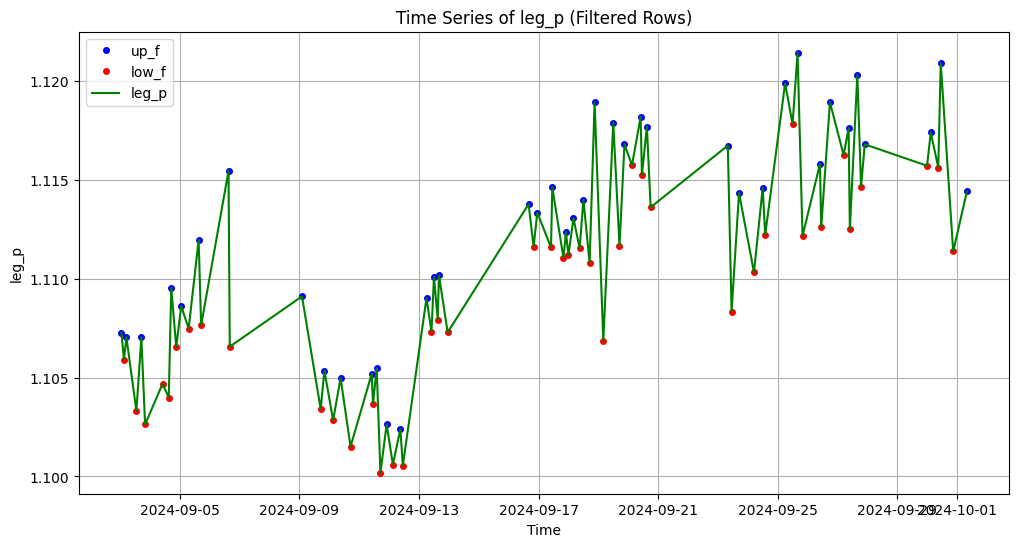

In [115]:
# انتخاب ردیف‌های خاص از دیتافریم
subset_fractals = fractals.iloc[-500:]  # انتخاب ردیف‌های 10 تا 20
# حذف سطرهایی که مقدار 'fra' آن‌ها False است
filtered_fractals = subset_fractals[subset_fractals['frac']]

# رسم نمودار
plt.figure(figsize=(12, 6))

# رسم نقاط up_f به رنگ آبی
plt.plot(filtered_fractals['time'][filtered_fractals['up_f']], filtered_fractals['leg_p']
         [filtered_fractals['up_f']], 'o', markersize=4, color='blue', label='up_f')

# رسم نقاط low_f به رنگ قرمز
plt.plot(filtered_fractals['time'][filtered_fractals['low_f']], filtered_fractals['leg_p']
         [filtered_fractals['low_f']], 'o', markersize=4, color='red', label='low_f')

# رسم نمودار خطی برای leg_p و اتصال نقاط
plt.plot(filtered_fractals['time'], filtered_fractals['leg_p'],
         '-', color='green', label='leg_p')

plt.xlabel('Time')
plt.ylabel('leg_p')
plt.title('Time Series of leg_p (Filtered Rows)')
plt.legend()
plt.grid(True)
plt.show()

In [116]:

# پیمایش معکوس ستون leg_p و جایگزینی مقادیر None
previous_value = None
for i in range(len(fractals)-1, -1, -1):
    if fractals.loc[i, 'leg_p'] is not None:
        previous_value = fractals.loc[i, 'leg_p']
    else:
        fractals.loc[i, 'leg_p'] = previous_value

fractals[-50:]

,time,O,H,L,C,vol,up_f,low_f,fra,frac,leg_p
99949,2024-09-27 12:00:00,1.11445,1.11597,1.11372,1.11594,2097,False,False,False,False,1.12029
99950,2024-09-27 13:00:00,1.11594,1.11709,1.11557,1.11633,1926,False,False,False,False,1.12029
99951,2024-09-27 14:00:00,1.11632,1.11676,1.11590,1.11624,1884,False,False,False,False,1.12029
99952,2024-09-27 15:00:00,1.11624,1.12015,1.11541,1.11996,3355,False,False,False,False,1.12029
99953,2024-09-27 16:00:00,1.11992,1.12029,1.11795,1.11852,3395,True,False,True,True,1.12029
99954,2024-09-27 17:00:00,1.11839,1.11920,1.11694,1.11784,3448,False,False,False,False,1.11464
99955,2024-09-27 18:00:00,1.11782,1.11782,1.11540,1.11584,2685,False,False,False,False,1.11464
99956,2024-09-27 19:00:00,1.11584,1.11599,1.11464,1.11516,2396,False,True,True,True,1.11464
99957,2024-09-27 20:00:00,1.11516,1.11658,1.11504,1.11636,2004,False,False,False,False,1.11678
99958,2024-09-27 21:00:00,1.11637,1.11677,1.11597,1.11677,1724,False,False,False,False,1.11678


شروع فرایند یادگیری ماشین

In [117]:
# به دلیل وجود None و اینکه مقدار صفر مناسب است و باعث ایجاد اشتباه نمیشود با صفر جایگزین شد
fractals['leg_p'] = fractals['leg_p'].fillna(0)

# تبدیل نوع ستون به نوع مناسب
fractals['leg_p'] = fractals['leg_p'].infer_objects(copy=False)

fractals

C:\Users\Administrator\AppData\Local\Temp\2\ipykernel_4532\464926547.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  fractals['leg_p'] = fractals['leg_p'].fillna(0)


,time,O,H,L,C,vol,up_f,low_f,fra,frac,leg_p
0,2008-08-13 11:00:00,1.49170,1.49370,1.49110,1.49190,928,False,False,False,False,1.4841
1,2008-08-13 12:00:00,1.49210,1.49210,1.48550,1.48710,1226,False,False,False,False,1.4841
2,2008-08-13 13:00:00,1.48700,1.49040,1.48630,1.48910,743,False,False,False,False,1.4841
3,2008-08-13 14:00:00,1.48900,1.49350,1.48890,1.49250,1106,False,False,False,False,1.4841
4,2008-08-13 15:00:00,1.49240,1.49240,1.48640,1.48710,1163,False,False,False,False,1.4841
...,...,...,...,...,...,...,...,...,...,...,...
99994,2024-10-01 09:00:00,1.11373,1.11410,1.11309,1.11344,1872,False,False,False,False,0.0000
99995,2024-10-01 10:00:00,1.11344,1.11370,1.11116,1.11149,3141,False,False,False,False,0.0000
99996,2024-10-01 11:00:00,1.11153,1.11201,1.10980,1.11016,2529,False,False,False,False,0.0000
99997,2024-10-01 12:00:00,1.11017,1.11144,1.10921,1.10951,2251,False,False,False,False,0.0000


In [118]:
fractals_data = fractals
fractals_data

,time,O,H,L,C,vol,up_f,low_f,fra,frac,leg_p
0,2008-08-13 11:00:00,1.49170,1.49370,1.49110,1.49190,928,False,False,False,False,1.4841
1,2008-08-13 12:00:00,1.49210,1.49210,1.48550,1.48710,1226,False,False,False,False,1.4841
2,2008-08-13 13:00:00,1.48700,1.49040,1.48630,1.48910,743,False,False,False,False,1.4841
3,2008-08-13 14:00:00,1.48900,1.49350,1.48890,1.49250,1106,False,False,False,False,1.4841
4,2008-08-13 15:00:00,1.49240,1.49240,1.48640,1.48710,1163,False,False,False,False,1.4841
...,...,...,...,...,...,...,...,...,...,...,...
99994,2024-10-01 09:00:00,1.11373,1.11410,1.11309,1.11344,1872,False,False,False,False,0.0000
99995,2024-10-01 10:00:00,1.11344,1.11370,1.11116,1.11149,3141,False,False,False,False,0.0000
99996,2024-10-01 11:00:00,1.11153,1.11201,1.10980,1.11016,2529,False,False,False,False,0.0000
99997,2024-10-01 12:00:00,1.11017,1.11144,1.10921,1.10951,2251,False,False,False,False,0.0000


نرمال سازی داده ها

In [119]:
from sklearn.preprocessing import MinMaxScaler
# در صورت تغییر به feature_range مورد نظر
scaler = MinMaxScaler(feature_range=(0, 1))

# انتخاب ستون‌هایی که می‌خواهیم نرمال کنیم
features_to_scale = ['O', 'H', 'L', 'C', 'vol', 'leg_p']

# اعمال MinMaxScaler به ستون‌های مورد نظر
fractals[features_to_scale] = scaler.fit_transform(fractals[features_to_scale])

# نمایش دیتا فریم نرمال شده
fractals[-50:]

,time,O,H,L,C,vol,up_f,low_f,fra,frac,leg_p
99949,2024-09-27 12:00:00,0.286525,0.286610,0.286189,0.289176,0.015777,False,False,False,False,0.739773
99950,2024-09-27 13:00:00,0.289184,0.288615,0.289495,0.289872,0.014490,False,False,False,False,0.739773
99951,2024-09-27 14:00:00,0.289863,0.288024,0.290085,0.289712,0.014174,False,False,False,False,0.739773
99952,2024-09-27 15:00:00,0.289720,0.294094,0.289209,0.296350,0.025246,False,False,False,False,0.739773
99953,2024-09-27 16:00:00,0.296288,0.294345,0.293748,0.293781,0.025547,True,False,True,True,0.739773
99954,2024-09-27 17:00:00,0.293557,0.292393,0.291943,0.292567,0.025946,False,False,False,False,0.736042
99955,2024-09-27 18:00:00,0.292540,0.289922,0.289191,0.288998,0.020203,False,False,False,False,0.736042
99956,2024-09-27 19:00:00,0.289006,0.286645,0.287833,0.287784,0.018027,False,True,True,True,0.736042
99957,2024-09-27 20:00:00,0.287792,0.287702,0.288548,0.289926,0.015077,False,False,False,False,0.737455
99958,2024-09-27 21:00:00,0.289952,0.288042,0.290210,0.290658,0.012969,False,False,False,False,0.737455


شروع یاد گیری ماشین

LSTM

In [120]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import numpy as np

# استفاده از ستون‌های O، H، L، C، vol به عنوان ورودی و ستون leg_p به عنوان هدف
data = fractals[['O', 'H', 'L', 'C', 'vol']].values
target = fractals['leg_p'].values

# ایجاد داده‌های سری زمانی برای مدل LSTM
X = []
y = []
n_steps = 10  # تعداد کندل‌های ورودی برای هر پیش‌بینی

for i in range(n_steps, len(data)):
    X.append(data[i-n_steps:i])
    y.append(data[i])

X, y = np.array(X), np.array(y)

# تقسیم‌بندی داده‌ها به مجموعه‌های آموزشی و تست
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# ساخت مدل LSTM
model = Sequential()
model.add(LSTM(units=5, return_sequences=True, input_shape=(n_steps, 5)))
model.add(Dropout(0.2))
model.add(LSTM(units=1))
model.add(Dropout(0.2))
model.add(Dense(1))

# بهینه‌سازی مدل با استفاده از Adam
model.compile(optimizer='adam', loss='mean_squared_error')

# آموزش مدل
model.fit(X_train, y_train, epochs=2, batch_size=32, validation_data=(X_test, y_test))

# پیش‌بینی برای کل داده‌ها (99999 پیش‌بینی)
total_predictions = 99999
predictions = []
input_data = X[-1].copy()  # آخرین داده ورودی برای شروع

for _ in range(total_predictions):
    # پیش‌بینی جدید
    prediction = model.predict(input_data.reshape(1, n_steps, 5))
    predictions.append(prediction[0, 0])  # ذخیره پیش‌بینی
    # به روزرسانی ورودی برای پیش‌بینی بعدی
    # از کندل‌های قدیمی استفاده کرده و پیش‌بینی جدید را اضافه می‌کنیم
    input_data = np.roll(input_data, -1, axis=0)  # رول کردن داده‌ها
    input_data[-1] = prediction  # قرار دادن پیش‌بینی جدید در آخرین ردیف

# تبدیل لیست پیش‌بینی‌ها به آرایه NumPy
lstm_predictions = np.array(predictions)

# حالا lstm_predictions دارای 99999 پیش‌بینی است


Epoch 1/2


c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 0.0775 - val_loss: 0.0137
Epoch 2/2
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0496 - val_loss: 0.0113
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/st

ARIMA

In [76]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# استفاده از ستون 'leg_p' به عنوان هدف برای پیش‌بینی
data = fractals['leg_p'].dropna()

# ایجاد و آموزش مدل ARIMA
model_arima = ARIMA(data, order=(5,1,0))  # پارامترهای (p, d, q) را بر اساس تحلیل داده‌ها تنظیم کنید
model_fit = model_arima.fit()

# پیش‌بینی
arima_predictions = model_fit.forecast(steps=50)


GRACH

In [77]:
from arch import arch_model

# استفاده از ستون 'leg_p' به عنوان هدف
data = fractals['leg_p'].dropna()

# ایجاد و آموزش مدل GARCH
model_garch = arch_model(data, vol='Garch', p=1, q=1)
model_fit_garch = model_garch.fit()

# پیش‌بینی نوسانات آتی
garch_predictions = model_fit_garch.forecast(horizon=50)



c:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.006684. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 9797991949141.324
Iteration:      2,   Func. Count:     21,   Neg. LLF: 72124137871.17244
Iteration:      3,   Func. Count:     32,   Neg. LLF: 242195.30049799723
Iteration:      4,   Func. Count:     39,   Neg. LLF: 13993724098.993406
Iteration:      5,   Func. Count:     51,   Neg. LLF: 21234720.98458255
Iteration:      6,   Func. Count:     62,   Neg. LLF: 172564.11078289655
Iteration:      7,   Func. Count:     69,   Neg. LLF: 484355172182.63873
Iteration:      8,   Func. Count:     84,   Neg. LLF: 9850332760.86059
Iteration:      9,   Func. Count:     96,   Neg. LLF: 3.4067326870291077e+18
Iteration:     10,   Func. Count:    107,   Neg. LLF: 3313621538.2173223
Iteration:     11,   Func. Count:    119,   Neg. LLF: -62959.17398808761
Optimization terminated successfully    (Exit mode 0)
            Current function value: -62959.175668060525
            Iterations: 15
            Function evaluations: 119
            Gradient ev

اضافه کردن پیش بینی ها به آرایه و چاپ نمودارها

In [78]:
# فرض می‌کنیم که garch_predictions یک شیء ARCHModelForecast است.
# برای دسترسی به پیش‌بینی‌ها از ویژگی‌های mean و variance استفاده می‌کنیم.
garch_predictions_values = garch_predictions.mean.values.flatten()  # پیش‌بینی‌های میانگین
# اگر به واریانس نیز نیاز دارید
garch_variance_values = garch_predictions.variance.values.flatten()

# حالا می‌توانیم بررسی کنیم که طول پیش‌بینی‌ها با test_size همخوانی دارد
if len(lstm_predictions) < test_size:
    lstm_predictions = np.append(lstm_predictions, [np.nan] * (test_size - len(lstm_predictions)))

if len(arima_predictions) < test_size:
    arima_predictions = np.append(arima_predictions, [np.nan] * (test_size - len(arima_predictions)))

if len(garch_predictions_values) < test_size:
    garch_predictions_values = np.append(garch_predictions_values, [np.nan] * (test_size - len(garch_predictions_values)))

# حالا پیش‌بینی‌ها را به دیتافریم اضافه می‌کنیم
fractals.iloc[-test_size:, fractals.columns.get_loc('lstm_predictions')] = lstm_predictions
fractals.iloc[-test_size:, fractals.columns.get_loc('arima_predictions')] = arima_predictions
fractals.iloc[-test_size:, fractals.columns.get_loc('garch_predictions')] = garch_predictions_values

# ترسیم نمودار مانند کد قبلی


# حالا می‌توانید نمودار را ترسیم کنید
plt.figure(figsize=(14, 8))

# ترسیم داده‌های اصلی (Close price)
plt.plot(fractals.index, fractals['C'], label='Original Close Price', color='blue')

# ترسیم پیش‌بینی‌های LSTM
plt.plot(fractals.index, fractals['lstm_predictions'], label='LSTM Predictions', color='green')

# ترسیم پیش‌بینی‌های ARIMA
plt.plot(fractals.index, fractals['arima_predictions'], label='ARIMA Predictions', color='orange')

# ترسیم پیش‌بینی‌های GARCH
plt.plot(fractals.index, fractals['garch_predictions'], label='GARCH Predictions', color='purple')

# برجسته کردن آخرین پیش‌بینی‌ها
last_idx = fractals.index[-1]  # آخرین ایندکس
plt.scatter(last_idx, fractals['lstm_predictions'].iloc[-1], color='green', s=100, edgecolors='black', label='Last LSTM Prediction')
plt.scatter(last_idx, fractals['arima_predictions'].iloc[-1], color='orange', s=100, edgecolors='black', label='Last ARIMA Prediction')
plt.scatter(last_idx, fractals['garch_predictions'].iloc[-1], color='purple', s=100, edgecolors='black', label='Last GARCH Prediction')

# تنظیمات نمودار
plt.title('Market Data and Predictions')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

# نمایش نمودار
plt.show()


KeyError: 'lstm_predictions'